### 算法赛：智慧海洋

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import warnings
from tqdm import tqdm,tqdm_notebook

from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn import metrics

import lightgbm as lgb
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns',100)
warnings.filterwarnings('ignore')
train_path = './input/train'
test_path = './input/test'
# os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表
train_file = os.listdir(train_path)
test_file = os.listdir(test_path)

In [28]:
# 正式加载数据并提取时间特征
train = pd.read_hdf('./input/train.h5')
test = pd.read_hdf('./input/test.h5')

In [29]:
train.head()

,ship,x,y,v,d,time,type
0,0,6.152038e+06,5.124873e+06,2.59,102,1110 11:58:19,拖网
1,0,6.151230e+06,5.125218e+06,2.70,113,1110 11:48:19,拖网
2,0,6.150421e+06,5.125563e+06,2.70,116,1110 11:38:19,拖网
3,0,6.149612e+06,5.125907e+06,3.29,95,1110 11:28:19,拖网
4,0,6.148803e+06,5.126252e+06,3.18,108,1110 11:18:19,拖网


根据baseline1的特征重要性，删去部分特征

In [30]:
# 特征工程
def group_feature(df,key,target,aggs):
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target}_{ag}'] = ag
    print(agg_dict)
    # 以key进行分组,选择特定的特征提取其函数结果作为新特征,函数包含在字典中
    t = df.groupby(key)[target].agg(agg_dict).reset_index()
    return t

def extract_feature(df,train):
    # ship指船号,对每一艘船的x,y,v,d的数据的特征进行提取
    t = group_feature(df, 'ship','x',['max','min','mean','std','skew','sum','count','median','mad'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','y',['max','min','mean','std','skew','sum','median','mad'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','v',['max','min','mean','std','skew','sum','median','mad'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','d',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    train['x_max_x_min'] = train['x_max'] - train['x_min']
    train['y_max_y_min'] = train['y_max'] - train['y_min']
    train['y_max_x_min'] = train['y_max'] - train['x_min']
    train['x_max_y_min'] = train['x_max'] - train['y_min']
    train['x_max_over_x_min'] = train['x_max'] / train['x_min']
    train['y_max_over_y_min'] = train['y_max'] / train['y_min']
    train['y_max_over_x_min'] = train['y_max'] / train['x_min']
    train['x_max_over_y_min'] = train['x_max'] / train['y_min']
    train['slope'] = train['y_max_y_min'] / np.where(train['x_max_x_min']==0, 0.001, train['x_max_x_min'])
    train['area'] = train['x_max_x_min'] * train['y_max_y_min']
    
    # mode_hour特征是指船号对应的出现频率最大的hour
    mode_hour = df.groupby('ship')['hour'].agg(lambda x:x.value_counts().index[0]).to_dict()
    # 用map将船号改为船号对应的mode_hour特征
    train['mode_hour'] = train['ship'].map(mode_hour)
    
    # 提取hour和date的独特数量的特征
    date_nunique = df.groupby('ship')['date'].nunique().to_dict()
    train['date_nunique'] = train['ship'].map(date_nunique)
    
    # 提取时间差特征,时间数据的形式缩写为dt
    t = df.groupby('ship')['time'].agg({'diff_time':lambda x:np.max(x)-np.min(x)}).reset_index()
    t['diff_day'] = t['diff_time'].dt.days
    t['diff_second'] = t['diff_time'].dt.seconds
    train = pd.merge(train, t, on='ship', how='left')
    return train

# 时间特征处理
def extract_dt(df):
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    # df['month'] = df['time'].dt.month
    # df['day'] = df['time'].dt.day
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    # df = df.drop_duplicates(['ship','month'])
    df['weekday'] = df['time'].dt.weekday
    return df

In [31]:
# 提取时间特征
train = extract_dt(train)
test = extract_dt(test)

# 提取所有特征
train_label = extract_feature(train,train)
test_label = extract_feature(test,test)

{'x_max': 'max', 'x_min': 'min', 'x_mean': 'mean', 'x_std': 'std', 'x_skew': 'skew', 'x_sum': 'sum', 'x_count': 'count', 'x_median': 'median', 'x_mad': 'mad'}
{'y_max': 'max', 'y_min': 'min', 'y_mean': 'mean', 'y_std': 'std', 'y_skew': 'skew', 'y_sum': 'sum', 'y_median': 'median', 'y_mad': 'mad'}
{'v_max': 'max', 'v_min': 'min', 'v_mean': 'mean', 'v_std': 'std', 'v_skew': 'skew', 'v_sum': 'sum', 'v_median': 'median', 'v_mad': 'mad'}
{'d_max': 'max', 'd_min': 'min', 'd_mean': 'mean', 'd_std': 'std', 'd_skew': 'skew', 'd_sum': 'sum'}
{'x_max': 'max', 'x_min': 'min', 'x_mean': 'mean', 'x_std': 'std', 'x_skew': 'skew', 'x_sum': 'sum', 'x_count': 'count', 'x_median': 'median', 'x_mad': 'mad'}
{'y_max': 'max', 'y_min': 'min', 'y_mean': 'mean', 'y_std': 'std', 'y_skew': 'skew', 'y_sum': 'sum', 'y_median': 'median', 'y_mad': 'mad'}
{'v_max': 'max', 'v_min': 'min', 'v_mean': 'mean', 'v_std': 'std', 'v_skew': 'skew', 'v_sum': 'sum', 'v_median': 'median', 'v_mad': 'mad'}
{'d_max': 'max', 'd_min':

In [32]:
# 将预测变量改为数值形式
type_map = dict(zip(train_label['type'].unique(),np.arange(3)))
type_map_rev = {v:k for k,v in type_map.items()}
train_label['type'] = train_label['type'].map(type_map)

In [33]:
train_label.shape

(2699638, 56)

In [34]:
train_label.head()

,ship,x,y,v,d,time,type,date,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_count,x_median,x_mad,y_max,y_min,y_mean,y_std,y_skew,y_sum,y_median,y_mad,v_max,v_min,v_mean,v_std,v_skew,v_sum,v_median,v_mad,d_max,d_min,d_mean,d_std,d_skew,d_sum,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,x_max_over_x_min,y_max_over_y_min,y_max_over_x_min,x_max_over_y_min,slope,area,mode_hour,date_nunique,diff_time,diff_day,diff_second
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,0,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,6.118352e+06,1905.724573,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,341.078408,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.0,0.49496,129,0,4.613527,21.24777,4.483093,1910,33686.667453,5907.975523,-987570.399385,1.027165e+06,1.005506,1.001153,0.838589,1.200427,0.17538,1.990200e+08,15,4,2 days 23:48:51,2,85731
1,0,6.151230e+06,5.125218e+06,2.70,113,1900-11-10 11:48:19,0,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,6.118352e+06,1905.724573,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,341.078408,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.0,0.49496,129,0,4.613527,21.24777,4.483093,1910,33686.667453,5907.975523,-987570.399385,1.027165e+06,1.005506,1.001153,0.838589,1.200427,0.17538,1.990200e+08,15,4,2 days 23:48:51,2,85731
2,0,6.150421e+06,5.125563e+06,2.70,116,1900-11-10 11:38:19,0,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,6.118352e+06,1905.724573,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,341.078408,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.0,0.49496,129,0,4.613527,21.24777,4.483093,1910,33686.667453,5907.975523,-987570.399385,1.027165e+06,1.005506,1.001153,0.838589,1.200427,0.17538,1.990200e+08,15,4,2 days 23:48:51,2,85731
3,0,6.149612e+06,5.125907e+06,3.29,95,1900-11-10 11:28:19,0,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,6.118352e+06,1905.724573,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,341.078408,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.0,0.49496,129,0,4.613527,21.24777,4.483093,1910,33686.667453,5907.975523,-987570.399385,1.027165e+06,1.005506,1.001153,0.838589,1.200427,0.17538,1.990200e+08,15,4,2 days 23:48:51,2,85731
4,0,6.148803e+06,5.126252e+06,3.18,108,1900-11-10 11:18:19,0,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,6.118352e+06,1905.724573,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,341.078408,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.0,0.49496,129,0,4.613527,21.24777,4.483093,1910,33686.667453,5907.975523,-987570.399385,1.027165e+06,1.005506,1.001153,0.838589,1.200427,0.17538,1.990200e+08,15,4,2 days 23:48:51,2,85731


In [35]:
ship_0_list = list(train_label[train_label['type']==0]['ship'].unique())
ship_1_list = list(train_label[train_label['type']==1]['ship'].unique())
ship_2_list = list(train_label[train_label['type']==2]['ship'].unique())

观察不同类型船只的速度变化模式

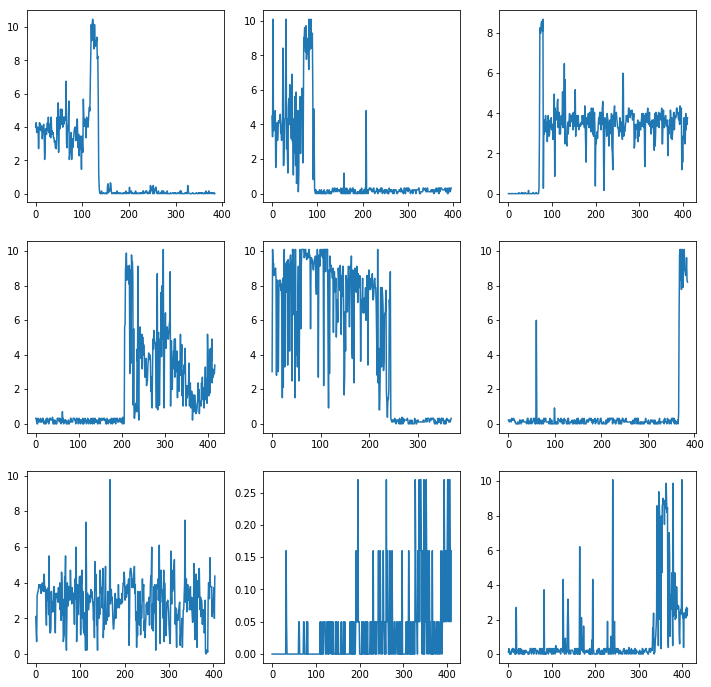

In [36]:
plt.figure(figsize=(12,12))
plt.subplot(331)
plt.plot(train[train['ship']==ship_0_list[1]]['v'])

plt.subplot(332)
plt.plot(train[train['ship']==ship_0_list[2]]['v'])
 
plt.subplot(333)
plt.plot(train[train['ship']==ship_0_list[3]]['v'])

plt.subplot(334)
plt.plot(train[train['ship']==ship_0_list[4]]['v'])

plt.subplot(335)
plt.plot(train[train['ship']==ship_0_list[5]]['v'])
 
plt.subplot(336)
plt.plot(train[train['ship']==ship_0_list[6]]['v'])

plt.subplot(337)
plt.plot(train[train['ship']==ship_0_list[7]]['v'])

plt.subplot(338)
plt.plot(train[train['ship']==ship_0_list[8]]['v'])

plt.subplot(339)
plt.plot(train[train['ship']==ship_0_list[9]]['v'])

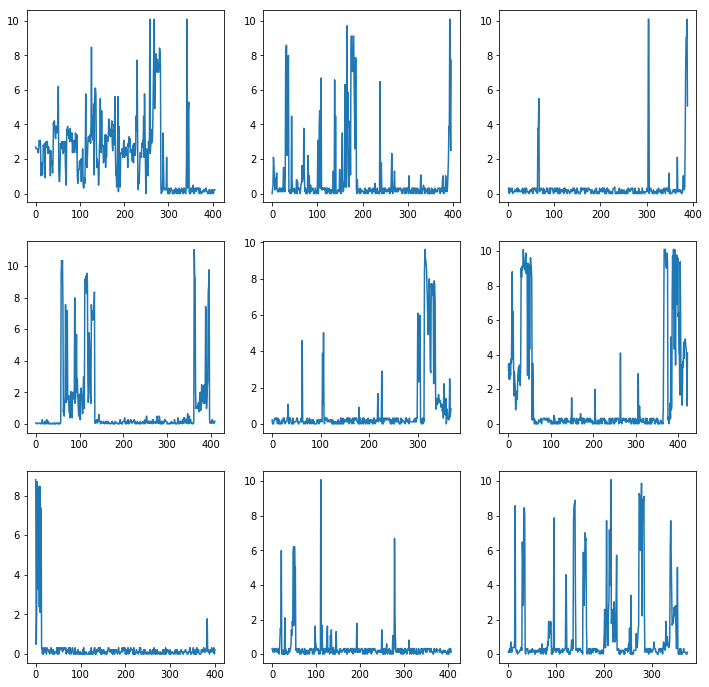

In [37]:
plt.figure(figsize=(12,12))
plt.subplot(331)
plt.plot(train[train['ship']==ship_1_list[1]]['v'])

plt.subplot(332)
plt.plot(train[train['ship']==ship_1_list[2]]['v'])
 
plt.subplot(333)
plt.plot(train[train['ship']==ship_1_list[3]]['v'])

plt.subplot(334)
plt.plot(train[train['ship']==ship_1_list[4]]['v'])

plt.subplot(335)
plt.plot(train[train['ship']==ship_1_list[5]]['v'])
 
plt.subplot(336)
plt.plot(train[train['ship']==ship_1_list[6]]['v'])

plt.subplot(337)
plt.plot(train[train['ship']==ship_1_list[7]]['v'])

plt.subplot(338)
plt.plot(train[train['ship']==ship_1_list[8]]['v'])

plt.subplot(339)
plt.plot(train[train['ship']==ship_1_list[9]]['v'])

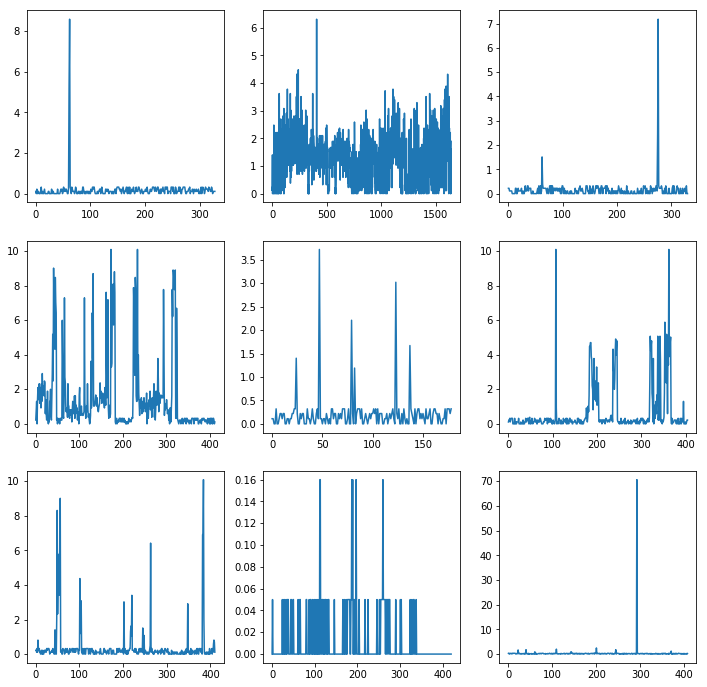

In [38]:
plt.figure(figsize=(12,12))
plt.subplot(331)
plt.plot(train[train['ship']==ship_2_list[1]]['v'])

plt.subplot(332)
plt.plot(train[train['ship']==ship_2_list[100]]['v'])
 
plt.subplot(333)
plt.plot(train[train['ship']==ship_2_list[30]]['v'])

plt.subplot(334)
plt.plot(train[train['ship']==ship_2_list[4]]['v'])

plt.subplot(335)
plt.plot(train[train['ship']==ship_2_list[5]]['v'])
 
plt.subplot(336)
plt.plot(train[train['ship']==ship_2_list[6]]['v'])

plt.subplot(337)
plt.plot(train[train['ship']==ship_2_list[7]]['v'])

plt.subplot(338)
plt.plot(train[train['ship']==ship_2_list[8]]['v'])

plt.subplot(339)
plt.plot(train[train['ship']==ship_2_list[9]]['v'])

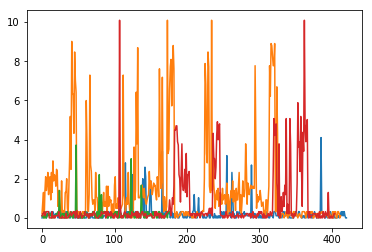

In [39]:
for i in range(3,7):
    loc = ship_2_list[i]
    t = train[train['ship']==loc]
    plt.plot(t['v'])

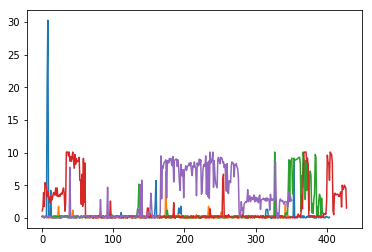

In [40]:
for i in range(20,25):
    loc = ship_1_list[i]
    t = train[train['ship']==loc]
    plt.plot(t['v'])

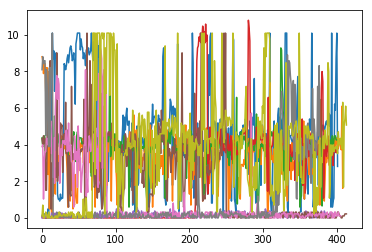

In [41]:
for i in range(10,19):
    loc = ship_0_list[i]
    t = train[train['ship']==loc]
    plt.plot(t['v'])

In [42]:
# 把之前的标签保存一下，有备无患
tr = train_label
te = test_label

In [43]:
# 每艘船都有很多数据,针对不同(x,y,v,d)提取的特征都是单个值,所以需要去重操作
train_label = train_label.drop_duplicates('ship')
test_label = test_label.drop_duplicates('ship')

In [44]:
train_label.shape

(7000, 56)

In [45]:
test_label.shape

(2000, 55)

In [46]:
train_label.head()

,ship,x,y,v,d,time,type,date,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_count,x_median,x_mad,y_max,y_min,y_mean,y_std,y_skew,y_sum,y_median,y_mad,v_max,v_min,v_mean,v_std,v_skew,v_sum,v_median,v_mad,d_max,d_min,d_mean,d_std,d_skew,d_sum,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,x_max_over_x_min,y_max_over_y_min,y_max_over_x_min,x_max_over_y_min,slope,area,mode_hour,date_nunique,diff_time,diff_day,diff_second
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,0,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,6.118352e+06,1905.724573,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,341.078408,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.00,0.494960,129,0,4.613527,21.247770,4.483093,1910,33686.667453,5907.975523,-9.875704e+05,1.027165e+06,1.005506,1.001153,0.838589,1.200427,0.175380,1.990200e+08,15,4,2 days 23:48:51,2,85731
414,1,6.076254e+06,5.061743e+06,3.99,278,1900-11-10 11:40:21,0,1900-11-10,11,5,6.102450e+06,6.049472e+06,6.091460e+06,16543.394419,-1.058454,2.345212e+09,385,6.102450e+06,14574.134228,5.112874e+06,5.042857e+06,5.094050e+06,26764.042729,-0.802446,1.961209e+09,5.112760e+06,24712.754023,10.47,0.0,1.607922,2.412688,1.590284,619.05,0.05,2.006849,336,0,56.153247,91.449382,1.418867,21619,52978.013345,70016.655842,-9.365979e+05,1.059593e+06,1.008757,1.013884,0.845177,1.210117,1.321617,3.709343e+09,19,4,2 days 23:39:47,2,85187
799,10,6.321032e+06,5.242805e+06,4.48,213,1900-11-10 11:49:36,0,1900-11-10,11,5,6.346913e+06,6.246119e+06,6.262484e+06,32280.567149,1.623040,2.486206e+09,397,6.246120e+06,25318.018154,5.265810e+06,5.229867e+06,5.242458e+06,5975.460236,2.198003,2.081256e+09,5.240937e+06,3556.709015,10.09,0.0,1.313854,2.442825,2.145410,521.60,0.22,1.779098,359,0,108.758186,112.515081,0.727645,43177,100794.674835,35942.703641,-9.803087e+05,1.117046e+06,1.016137,1.006873,0.843053,1.213590,0.356593,3.622833e+09,23,4,2 days 23:33:53,2,84833
1196,100,6.102751e+06,5.112534e+06,0.00,0,1900-10-30 23:50:05,0,1900-10-30,23,1,6.151439e+06,6.102326e+06,6.123711e+06,14451.941954,0.021860,2.516845e+09,411,6.123431e+06,12392.343016,5.112752e+06,5.069616e+06,5.085480e+06,14020.260117,1.055676,2.090132e+09,5.082056e+06,10839.543586,8.69,0.0,2.965864,1.647069,-0.215287,1218.97,3.45,1.196892,353,0,161.727494,115.409256,-0.020073,66470,49113.022232,43135.705758,-9.895740e+05,1.081823e+06,1.008048,1.008509,0.837837,1.213393,0.878295,2.118525e+09,11,3,2 days 23:48:47,2,85727
1607,1000,6.843713e+06,5.480538e+06,2.00,216,1900-11-06 23:42:30,1,1900-11-06,23,1,6.844414e+06,6.748890e+06,6.807536e+06,26263.537565,-0.770190,2.566441e+09,377,6.809206e+06,18041.318374,5.540087e+06,5.440815e+06,5.464764e+06,30135.645906,1.412544,2.060216e+09,5.450299e+06,23649.086501,8.90,0.0,2.085570,2.649306,1.110173,786.26,0.59,2.247028,358,0,159.143236,101.832626,0.217397,59997,95524.035775,99271.486171,-1.208803e+06,1.403598e+06,1.014154,1.018246,0.820889,1.257976,1.039230,9.482813e+09,0,3,2 days 23:37:11,2,85031


In [47]:
feats = [i for i in train_label.columns if i not in ['ship','type','time','diff_time','date']]
target = 'type'

In [48]:
train_label.head()

,ship,x,y,v,d,time,type,date,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_count,x_median,x_mad,y_max,y_min,y_mean,y_std,y_skew,y_sum,y_median,y_mad,v_max,v_min,v_mean,v_std,v_skew,v_sum,v_median,v_mad,d_max,d_min,d_mean,d_std,d_skew,d_sum,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,x_max_over_x_min,y_max_over_y_min,y_max_over_x_min,x_max_over_y_min,slope,area,mode_hour,date_nunique,diff_time,diff_day,diff_second
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,0,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,6.118352e+06,1905.724573,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,341.078408,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.00,0.494960,129,0,4.613527,21.247770,4.483093,1910,33686.667453,5907.975523,-9.875704e+05,1.027165e+06,1.005506,1.001153,0.838589,1.200427,0.175380,1.990200e+08,15,4,2 days 23:48:51,2,85731
414,1,6.076254e+06,5.061743e+06,3.99,278,1900-11-10 11:40:21,0,1900-11-10,11,5,6.102450e+06,6.049472e+06,6.091460e+06,16543.394419,-1.058454,2.345212e+09,385,6.102450e+06,14574.134228,5.112874e+06,5.042857e+06,5.094050e+06,26764.042729,-0.802446,1.961209e+09,5.112760e+06,24712.754023,10.47,0.0,1.607922,2.412688,1.590284,619.05,0.05,2.006849,336,0,56.153247,91.449382,1.418867,21619,52978.013345,70016.655842,-9.365979e+05,1.059593e+06,1.008757,1.013884,0.845177,1.210117,1.321617,3.709343e+09,19,4,2 days 23:39:47,2,85187
799,10,6.321032e+06,5.242805e+06,4.48,213,1900-11-10 11:49:36,0,1900-11-10,11,5,6.346913e+06,6.246119e+06,6.262484e+06,32280.567149,1.623040,2.486206e+09,397,6.246120e+06,25318.018154,5.265810e+06,5.229867e+06,5.242458e+06,5975.460236,2.198003,2.081256e+09,5.240937e+06,3556.709015,10.09,0.0,1.313854,2.442825,2.145410,521.60,0.22,1.779098,359,0,108.758186,112.515081,0.727645,43177,100794.674835,35942.703641,-9.803087e+05,1.117046e+06,1.016137,1.006873,0.843053,1.213590,0.356593,3.622833e+09,23,4,2 days 23:33:53,2,84833
1196,100,6.102751e+06,5.112534e+06,0.00,0,1900-10-30 23:50:05,0,1900-10-30,23,1,6.151439e+06,6.102326e+06,6.123711e+06,14451.941954,0.021860,2.516845e+09,411,6.123431e+06,12392.343016,5.112752e+06,5.069616e+06,5.085480e+06,14020.260117,1.055676,2.090132e+09,5.082056e+06,10839.543586,8.69,0.0,2.965864,1.647069,-0.215287,1218.97,3.45,1.196892,353,0,161.727494,115.409256,-0.020073,66470,49113.022232,43135.705758,-9.895740e+05,1.081823e+06,1.008048,1.008509,0.837837,1.213393,0.878295,2.118525e+09,11,3,2 days 23:48:47,2,85727
1607,1000,6.843713e+06,5.480538e+06,2.00,216,1900-11-06 23:42:30,1,1900-11-06,23,1,6.844414e+06,6.748890e+06,6.807536e+06,26263.537565,-0.770190,2.566441e+09,377,6.809206e+06,18041.318374,5.540087e+06,5.440815e+06,5.464764e+06,30135.645906,1.412544,2.060216e+09,5.450299e+06,23649.086501,8.90,0.0,2.085570,2.649306,1.110173,786.26,0.59,2.247028,358,0,159.143236,101.832626,0.217397,59997,95524.035775,99271.486171,-1.208803e+06,1.403598e+06,1.014154,1.018246,0.820889,1.257976,1.039230,9.482813e+09,0,3,2 days 23:37:11,2,85031


In [49]:
X = train_label[feats].copy()
y = train_label[target]

模型融合

In [57]:
class Create_Ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
#         X = np.array(X)
#         y = np.array(y)
#         T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2020).split(X, y))
        # 底层模型对训练集的预测值作为上层模型的特征去进行训练
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        # 底层模型对测试集的预测值作为上层模型的测试集去进行预测
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        # 对模型进行迭代
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            pred = np.zeros((len(test_label),3))
            oof = np.zeros((len(X),3))
            # K折交叉验证
            for j, (train_idx, valid_idx) in enumerate(folds):                
                # 使用原生接口时,数据格式要符合lightgbm的格式
                train_set = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])
                val_set = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx])

                model = clf.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=None)
                # val_pred是nrows * n_class的形式,且形式为概率值
                val_proba = model.predict(X.iloc[val_idx])
                oof[val_idx] = val_proba
                val_pred = np.argmax(val_proba, axis=1)
                S_train[val_idx,i] = val_pred
                val_y = y.iloc[val_idx]
                print('Fold{} '.format(j+1), 'val f1', metrics.f1_score(val_y, val_pred, average='macro'))
                
                # pred是对test标签的预测
                test_proba = model.predict(test_label[feats])
                test_pred = np.argmax(test_proba,axis=1)
                pred += test_proba/self.n_splits
                
            oof = np.argmax(oof, axis=1)
            print('model {} oof f1'.format(i+1), metrics.f1_score(oof, y, average='macro'))
            S_test[:, i] = np.argmax(pred,axis=1)
            
        return S_train, S_test

In [58]:
params = {
    'n_estimators': 2000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 100,
    'max_depth': 6,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'lambda_l2':0.05
}

第一层效果不佳

In [59]:
models = [lgb,lgb]
lgb_stack = Create_Ensemble(n_splits = 2, base_models = models)        
X1 = X.copy()
Y1 = y.copy()
T1 = test_label.copy()[feats]
lgb_train_pred, lgb_test_pred = lgb_stack.predict(X1, Y1, T1)

Fold1  val f1 0.9271772676350452
Fold2  val f1 0.926076485751509
model 1 oof f1 0.6863491918242048
Fold1  val f1 0.9271772676350452
Fold2  val f1 0.926076485751509
model 2 oof f1 0.6863491918242048


In [60]:
lgb_train_pred

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [2., 2.],
       [0., 0.],
       [0., 0.]])

In [61]:
lgb_test_pred.shape

(2000, 2)

In [90]:
XX = pd.DataFrame(lgb_train_pred)

In [93]:
XX[0] = XX[0].apply(str)
XX[1] = XX[1].apply(str)

In [94]:
XX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 2 columns):
0    7000 non-null object
1    7000 non-null object
dtypes: object(2)
memory usage: 109.5+ KB


In [96]:
XX.head()

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,1.0


两个LGB做底层，一个LGB做顶层

In [97]:
new_X = pd.get_dummies(XX)

In [99]:
new_X.head()

,0_0.0,0_1.0,0_2.0,1_0.0,1_1.0,1_2.0
0,1,0,0,1,0,0
1,1,0,0,1,0,0
2,1,0,0,1,0,0
3,1,0,0,1,0,0
4,0,1,0,0,1,0


In [69]:
params = {
    'n_estimators': 2000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 100,
}

In [100]:
XX = new_X

In [101]:
# 五折交叉验证
fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# 准备预测
models = []
pred = np.zeros((len(test_label),3))
oof = np.zeros((len(X),3))

for index, (train_idx, val_idx) in enumerate(fold.split(XX, y)):

    train_set = lgb.Dataset(XX.iloc[train_idx], y.iloc[train_idx])
    val_set = lgb.Dataset(XX.iloc[val_idx], y.iloc[val_idx])

    model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=None)
    models.append(model)
    val_pred = model.predict(XX.iloc[val_idx])
    oof[val_idx] = val_pred
    val_y = y.iloc[val_idx]
    val_pred = np.argmax(val_pred, axis=1)
    print(index+1, 'val f1', metrics.f1_score(val_y, val_pred, average='macro'))

    test_pred = model.predict(test_label[feats])
    pred += test_pred/5

oof = np.argmax(oof, axis=1)
print('oof f1', metrics.f1_score(oof, y, average='macro'))

1 val f1 0.2558241758241758
2 val f1 0.255868544600939
3 val f1 0.6850158029373444
4 val f1 0.9323175496171276
5 val f1 0.9219204741377584
oof f1 0.6863491918242048


融合效果不佳,尝试单模型增加到10折

In [102]:
# 五折交叉验证
fold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
# 准备预测
models = []
pred = np.zeros((len(test_label),3))
oof = np.zeros((len(X),3))

params = {
    'n_estimators': 5000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 500,
}

for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):

    train_set = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])
    val_set = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx])

    model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=None)
    models.append(model)
    val_pred = model.predict(X.iloc[val_idx])
    oof[val_idx] = val_pred
    val_y = y.iloc[val_idx]
    val_pred = np.argmax(val_pred, axis=1)
    print(index, 'val f1', metrics.f1_score(val_y, val_pred, average='macro'))

    test_pred = model.predict(test_label[feats])
    pred += test_pred/10

oof = np.argmax(oof, axis=1)
print('oof f1', metrics.f1_score(oof, y, average='macro'))

0 val f1 0.8706619820108914
1 val f1 0.8961136435263538
2 val f1 0.8771196916162637
3 val f1 0.8803641291390547
4 val f1 0.882312004684073
5 val f1 0.871068985915052
6 val f1 0.8913097425720841
7 val f1 0.8800605340707598
8 val f1 0.8850965845137498
9 val f1 0.8701234419371703
oof f1 0.8803444367173731


In [104]:
# 创建提交文件
pred = np.argmax(pred, axis=1)
sub = test_label[['ship']]
sub['pred'] = pred

print(sub['pred'].value_counts(1))
sub['pred'] = sub['pred'].map(type_map_rev)
sub.to_csv('./output/new_baseline2_result.csv', index=None, header=None)

0    0.6315
1    0.2335
2    0.1350
Name: pred, dtype: float64


In [105]:
# 查看特征重要性
ret = []
for index, model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = model.feature_name()
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)
    
df = pd.concat(ret)
df = df.groupby('name', as_index=False)['score'].mean()
df = df.sort_values(['score'], ascending=False)
df

,name,score
34,x_min,569.1
40,y_max,555.1
41,y_max_over_x_min,522.8
43,y_max_x_min,512.8
18,v_median,473.1
33,x_median,473.1
35,x_skew,456.8
46,y_median,456.3
48,y_skew,449.6
29,x_max_over_y_min,448.2
